In [10]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [12]:
# carga datos reales
(X_train, _), (_, _) = mnist.load_data()

# Reescalar las imagenes de -1 a 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

In [13]:
(buffer_size,img_rows, img_cols, channels) = X_train.shape
img_shape  = (img_rows, img_cols, channels)
z_dim      = 250
batch_size = 256
num_epochs = 260
each_save  = 126 # codigo estudiante
path_results = 'dcgan_results/'

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

In [15]:
from tensorflow.keras.utils import plot_model

def build_generator(img_shape, z_dim, verbose=False):

    z = Input(shape=(z_dim,))

    X = Dense(256 * 7 * 7, input_dim=z_dim) (z)
    X = Reshape((7, 7, 256))(X)

    X = Conv2DTranspose(filters=128, kernel_size=3, strides    =2, padding    ='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.01)(X)

    X = Conv2DTranspose(filters=64,kernel_size=3,strides    =1,padding    ='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.01)(X)

    Y = Conv2DTranspose(filters=1,kernel_size=3, strides    =2, padding    ='same', activation ='tanh')(X)

    generator_model = Model(inputs = z, outputs = [Y], name ='generator')

    return generator_model

In [16]:
generator = build_generator(img_shape, z_dim)

In [17]:
def build_discriminator(img_shape, verbose=False):

    Xin = Input(shape=(img_shape[0],img_shape[1],img_shape[2],))


    X = Conv2D(filters     = 32, kernel_size = 3, strides     = 2, input_shape = img_shape, padding     = 'same')(Xin)
    X = LeakyReLU(alpha    = 0.01)(X)

    X = Conv2D(filters     = 64, kernel_size = 3, strides     = 2, padding     = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha    = 0.01)(X)

    X = Conv2D(filters     = 128, kernel_size = 3, strides     = 2, padding     = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha    = 0.01)(X)

    X = Flatten()(X)
    Yout = Dense(1, activation='sigmoid')(X)

    discriminator_model = Model(inputs = Xin, outputs = [Yout], name ='discriminator')

    return discriminator_model

In [18]:
discriminator = build_discriminator(img_shape)

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss_classic(real_output, fake_output):

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_loss(real_output, fake_output):

    total_loss = -tf.reduce_mean(tf.keras.backend.log(real_output) + tf.keras.backend.log(1.- fake_output))
    return total_loss

In [20]:
def generator_loss_classic(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generator_loss(real_output,fake_output):

    total_loss = -tf.reduce_mean(tf.keras.backend.log(fake_output))
    return total_loss

In [21]:
generator_optimizer     = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
@tf.function
def train_step(images):
    '''

    Implementa un paso de entrenamiento para la GAN

    Recibe como parámetros un semi-lote de imágenes reales
    '''

    z = tf.random.normal([images.shape[0], z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(z, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss  = generator_loss(real_output, fake_output)


    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [23]:
from PIL import Image
import imageio
import glob

# Crea una collage de imágenes con el Generador y la guarda

num_examples_to_generate = 16 # (4,4)
seed = tf.random.normal([num_examples_to_generate, z_dim])

def generate_and_save_images(model, epoch, test_input, pathdir=path_results):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(pathdir+'image_epch_{:04d}.png'.format(epoch))
    plt.show()


# Despliega la imagen correspondiente a una época

def display_image(epoch_no, pathdir=path_results):
    return Image.open(pathdir+'image_epch_{:04d}.png'.format(epoch_no))

In [24]:
from IPython import display
import time

def train(dataset, epochs):

    generator_losses=[]
    discriminator_losses=[]
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        generator_losses.append(gen_loss)
        discriminator_losses.append(disc_loss)

        if (epoch+1)%each_save ==0:

            generate_and_save_images(generator,
                                     epoch + 1,
                                     seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    generate_and_save_images(generator,
                               epochs,
                               seed)

    return np.array(generator_losses), np.array(discriminator_losses)

Time for epoch 1 is 22.892805814743042 sec
Time for epoch 2 is 6.453110456466675 sec
Time for epoch 3 is 6.492868185043335 sec
Time for epoch 4 is 6.529866933822632 sec
Time for epoch 5 is 6.5674519538879395 sec
Time for epoch 6 is 6.511213302612305 sec
Time for epoch 7 is 6.502355098724365 sec
Time for epoch 8 is 6.490089178085327 sec
Time for epoch 9 is 6.527367830276489 sec
Time for epoch 10 is 6.564980983734131 sec
Time for epoch 11 is 6.631117820739746 sec
Time for epoch 12 is 6.689711332321167 sec
Time for epoch 13 is 6.7530317306518555 sec
Time for epoch 14 is 6.696315288543701 sec
Time for epoch 15 is 6.726851224899292 sec
Time for epoch 16 is 6.664020776748657 sec
Time for epoch 17 is 6.632899522781372 sec
Time for epoch 18 is 6.620932102203369 sec
Time for epoch 19 is 6.597164869308472 sec
Time for epoch 20 is 6.595254182815552 sec
Time for epoch 21 is 6.5935375690460205 sec
Time for epoch 22 is 6.611136198043823 sec
Time for epoch 23 is 6.620696783065796 sec
Time for epoch 2

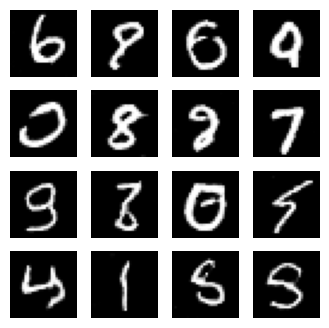

Time for epoch 126 is 7.190630674362183 sec
Time for epoch 127 is 6.635542154312134 sec
Time for epoch 128 is 6.6310200691223145 sec
Time for epoch 129 is 6.616318702697754 sec
Time for epoch 130 is 6.626845121383667 sec
Time for epoch 131 is 6.6244282722473145 sec
Time for epoch 132 is 6.63104510307312 sec
Time for epoch 133 is 6.631177663803101 sec
Time for epoch 134 is 10.22670292854309 sec
Time for epoch 135 is 6.669676065444946 sec
Time for epoch 136 is 6.615947246551514 sec
Time for epoch 137 is 6.639643430709839 sec
Time for epoch 138 is 6.65842342376709 sec
Time for epoch 139 is 6.699808597564697 sec
Time for epoch 140 is 6.670001983642578 sec
Time for epoch 141 is 6.668776512145996 sec
Time for epoch 142 is 6.637862920761108 sec
Time for epoch 143 is 6.620420455932617 sec
Time for epoch 144 is 6.619142055511475 sec
Time for epoch 145 is 10.221384763717651 sec
Time for epoch 146 is 6.665671348571777 sec
Time for epoch 147 is 6.608501195907593 sec
Time for epoch 148 is 6.6224551

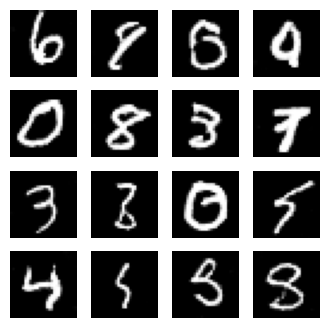

Time for epoch 252 is 7.319934844970703 sec
Time for epoch 253 is 6.665153503417969 sec
Time for epoch 254 is 6.63489031791687 sec
Time for epoch 255 is 6.615760326385498 sec
Time for epoch 256 is 6.616038084030151 sec
Time for epoch 257 is 6.6108434200286865 sec
Time for epoch 258 is 6.621793985366821 sec
Time for epoch 259 is 6.615079641342163 sec
Time for epoch 260 is 6.668819427490234 sec


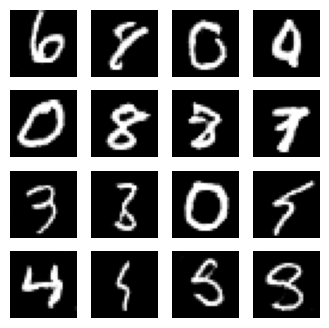

In [25]:
generator_losses, discriminator_losses = train(train_dataset, num_epochs)

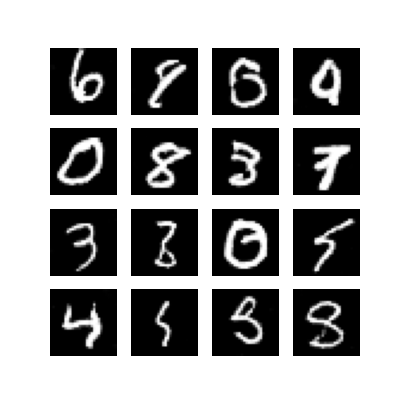

In [32]:
display_image(252)

In [27]:
generator.save_weights('dcgan_generator_0_1.h5')
discriminator.save_weights('dcgan_discriminator_0_1.h5')

Text(0.5, 1.0, 'PERDIDA DEL DISCRIMINADOR')

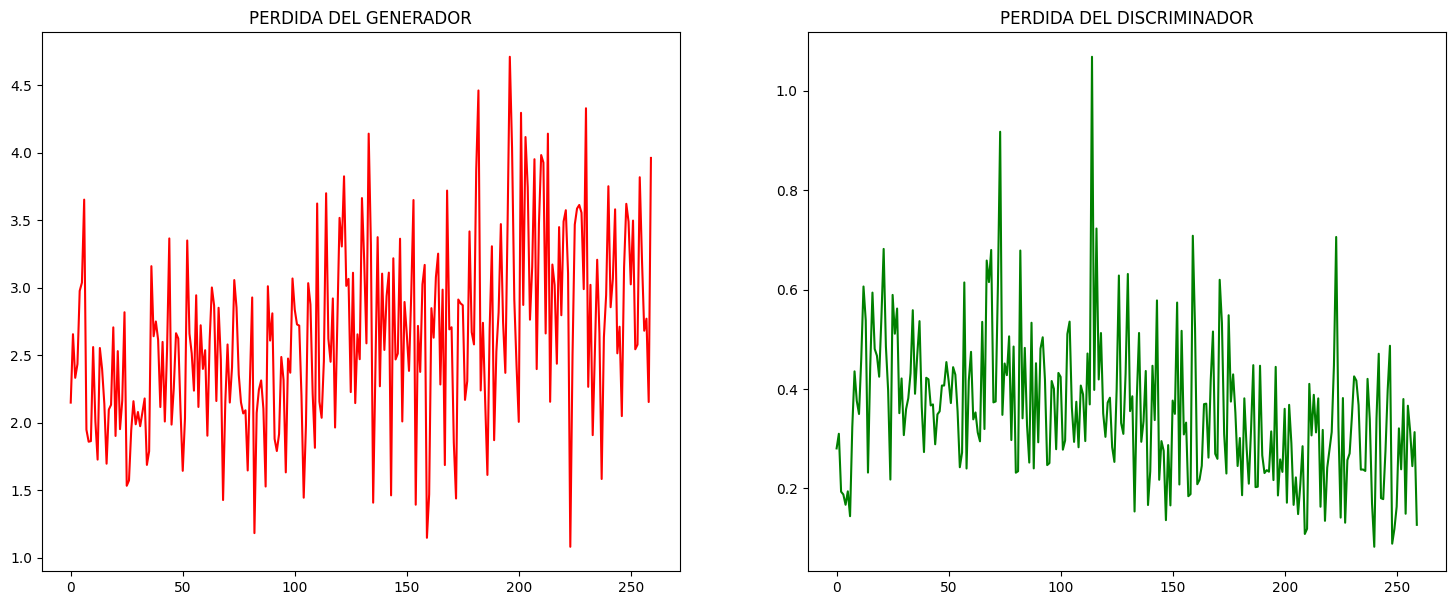

In [28]:
plt.figure(figsize=(28,7))
plt.subplot(131)
plt.plot(generator_losses, 'r')
plt.title('PERDIDA DEL GENERADOR')
plt.subplot(132)
plt.plot(discriminator_losses, 'g')
plt.title('PERDIDA DEL DISCRIMINADOR')
